In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
!unzip a-large-scale-fish-dataset.zip

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import random
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [20]:
# Dataset path 
dataset_path = '/content/Fish_Dataset/Fish_Dataset'

fish_classes = os.listdir(dataset_path) 
print(fish_classes)

['Red Mullet', 'Sea Bass', 'Striped Red Mullet', 'Hourse Mackerel', 'Trout', 'Black Sea Sprat', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


In [21]:
# Loading the dataset
training_data = []
IMG_SIZE = 75
def create_training_data():
    for fish_class in fish_classes:
        path = os.path.join(dataset_path, fish_class)
        class_num = fish_classes.index(fish_class)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA)
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
        

create_training_data()
print(len(training_data))

9000


In [22]:
# Shuffling the dataset
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

# Splitting the dataset into features and labels
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

# Converting the features and labels into numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

6
2
2
8
5
2
4
6
5
0


In [23]:
# Normalizing the features
X = X / 255.0

In [24]:
# One hot encoding the labels
y = to_categorical(y, num_classes = 9)

# Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Building the inceptionV3 model
inceptionV3 = InceptionV3(weights = "imagenet", include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))

# Adding the layers to the inceptionV3 model
model = Sequential()
model.add(inceptionV3)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(9, activation = "softmax"))

# Compiling the inceptionV3 model
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Fitting the inceptionV3 model to the training set
model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data = (X_test, y_test))

# Saving the inceptionV3 model
model.save("inceptionV3.model")

# Loading the inceptionV3 model
model = tf.keras.models.load_model("inceptionV3.model")

# Evaluating the inceptionV3 model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
# Printing the name of the fish class
print(fish_classes[y_pred[0]])


87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/20
225/225 [==============================] - 34s 66ms/step - loss: 1.6022 - accuracy: 0.4408 - val_loss: 3.2096 - val_accuracy: 0.3283
Epoch 2/20
225/225 [==============================] - 13s 56ms/step - loss: 0.9671 - accuracy: 0.6751 - val_loss: 82.3617 - val_accuracy: 0.1978
Epoch 3/20
225/225 [==============================] - 13s 57ms/step - loss: 0.8729 - accuracy: 0.7072 - val_loss: 3.2228 - val_accuracy: 0.1217
Epoch 4/20
225/225 [==============================] - 13s 56ms/step - loss: 0.5205 - accuracy: 0.8354 - val_loss: 1.1151 - val_accuracy: 0.6767
Epoch 5/20
225/225 [==============================] - 13s 57ms/step - loss: 1.0326 - accuracy: 0.6483 - val_loss: 33.3167 - val_accuracy: 0.1372
Epoch 6/20
225/225 [==============================] - 13s 57ms/step - loss: 0.8748 - accuracy: 0.6936 - val_loss: 1.0659 - val_accuracy: 0.6011
Epoch 7/20
225/225 [==============================] - 13s 59ms/step -

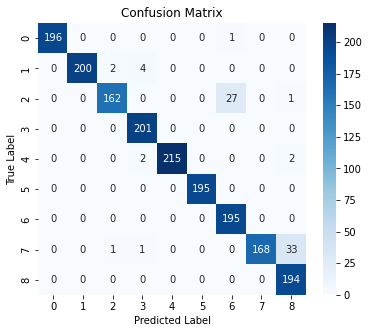

In [32]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [34]:
print(classification_report(y_test, y_pred, target_names = fish_classes))

                    precision    recall  f1-score   support

        Red Mullet       1.00      0.99      1.00       197
          Sea Bass       1.00      0.97      0.99       206
Striped Red Mullet       0.98      0.85      0.91       190
   Hourse Mackerel       0.97      1.00      0.98       201
             Trout       1.00      0.98      0.99       219
   Black Sea Sprat       1.00      1.00      1.00       195
            Shrimp       0.87      1.00      0.93       195
   Gilt-Head Bream       1.00      0.83      0.91       203
     Red Sea Bream       0.84      1.00      0.92       194

          accuracy                           0.96      1800
         macro avg       0.96      0.96      0.96      1800
      weighted avg       0.96      0.96      0.96      1800

